In [46]:
import h5py
import numpy as np
from constant import *
import matplotlib.pyplot as plt
import torch
from utils import test_dataloader
from torch.autograd import Variable
from sklearn.metrics import *

In [7]:
file = '%s/densenet121/%s/stat.h5' % (LOG_DIR, '20180426-065637')
f = h5py.File(file, 'r')
for k in f.keys():
    print(k)

train_auc
train_loss
val_auc
val_loss


Text(0.5,1,'loss')

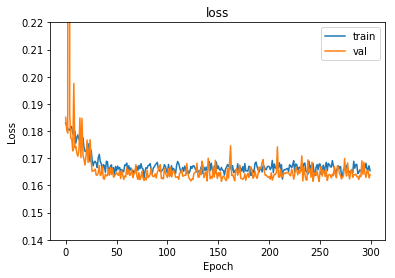

In [23]:
plt.plot(f['train_loss'].value, label='train')
plt.plot(f['val_loss'].value, label='val')
plt.legend()
plt.ylim([0.14, 0.22])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss')

Text(0.5,1,'AUC')

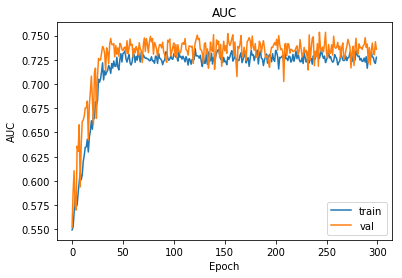

In [24]:
plt.plot(f['train_auc'].value, label='train')
plt.plot(f['val_auc'].value, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC')

In [62]:
from models.densenet121 import DenseNet121
model_name = '%s/densenet121/%s/model.path.tar' %(MODEL_DIR, '20180422-075022')
net = DenseNet121(14).cuda()
model = torch.nn.DataParallel(net, device_ids=[0]).cuda()
checkpoint = torch.load(model_name)
model.load_state_dict(checkpoint['state_dict'])
dataloader = test_dataloader(image_list_file=CHEXNET_TEST_CSV, percentage=1, agumented=False)

In [63]:
model.eval()
targets = torch.FloatTensor()
targets = targets.cuda()
preds = torch.FloatTensor()
preds = preds.cuda()
    
for data, target in dataloader:
    target = target.cuda()
    data = Variable(data.cuda(), volatile=True)
    pred = model(data)
    targets = torch.cat((targets, target), 0)
    preds = torch.cat((preds, pred.data), 0)


In [64]:
aurocs = []
ytests = targets.cpu().numpy()
yscores = preds.cpu().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(targets[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Text(0,0.5,'True positive rate')

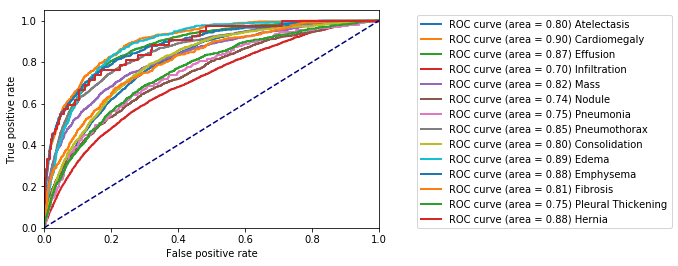

In [66]:
lw= 2
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=lw,
            label='ROC curve (area = %0.2f) %s' % (roc_auc[i], CLASS_NAMES[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(bbox_to_anchor=[1.1, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')